In [9]:
def get_relevant_activations(data, markup_for_tag):
    result = []
    for i, tag in enumerate(markup_for_tag):
        if tag != 0:
            result.append(data[i])
    return np.stack(result)


def get_matches(activations, markup):
    markup = np.array(markup)
    markup_devs = markup - np.mean(markup)
    activation_devs = activations - np.mean(activations, 0, keepdims=True)
    activation_stddevs = np.std(activations, 0, ddof=1, keepdims=True)
    markup_stddev = np.std(markup, ddof=1)
    activation_dev_fractions = activation_devs / (activation_stddevs + 1e-20)
    markup_dev_fractions = markup_devs / (markup_stddev + 1e-20)
    return activation_dev_fractions * np.reshape(markup_dev_fractions, [-1, 1])


def compute_stats(data, markup_for_tag):
    markup_for_tag = np.array(markup_for_tag)
    stats = {}
    stats['markup'] = markup_for_tag
    stats['relevant_markup'] = list(filter(lambda x: x != 0, markup_for_tag))
    stats['relevant_activations'] = get_relevant_activations(data, markup_for_tag)
    stats['matches'] = get_matches(stats['relevant_activations'], stats['relevant_markup'])
    stats['correlations'] = np.mean(stats['matches'], 0)
    assert stats['correlations'].ndim == 1
    stats['match_stddevs'] = np.std(stats['matches'], 0)
    stats['mean_square_correlation'] = np.sqrt(np.mean(stats['correlations']**2))
    stats['meta'] = {
        "positive": np.count_nonzero(markup_for_tag == 1),
        "negative": np.count_nonzero(markup_for_tag == -1),
        "total": len(stats['markup']),
    }
    return stats

In [11]:
import os
import pickle
import numpy as np

os.makedirs('test', exist_ok=True)

with open("test/test.pickle", 'wb') as f:
    pickle.dump(np.array([[4]*10]*50), f)

In [12]:
! ls -l test

итого 8
-rw-rw-r-- 1 anton anton 4160 июн  7 11:29 test.pickle


In [5]:
import tensorflow as tf

def get_axis_quarters(tensor):
    last_dim = tf.shape(tensor, out_type=tf.float32)[-1]
    exponents = tf.range(0., last_dim, 1., dtype=tf.float32)
    powers = tf.math.pow(2., exponents)
    binary_format = tf.cast(tensor > 0, tf.float32)
    linear_combination = powers * binary_format
    numbers = tf.reduce_sum(linear_combination, axis=-1)
    return tf.cast(numbers, tf.int32)

tensor = tf.constant(
    [[1, -1, 1],
     [-1, -1, -1]]
)

axis_quarters = get_axis_quarters(tensor)

with tf.Session() as sess:
    print(sess.run(axis_quarters))

[5 0]


In [1]:
import pickle
import numpy as np

prefix = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS'

tmpl = os.path.join(prefix, '{}.pickle')

In [ ]:
file_name = tmpl.format('correlations')
with open(file_name, 'rb') as f:
    corr = pickle.load(f)
    
print(max(corr))
print(np.argmax(corr))

In [1]:
from collections import Counter
import numpy as np

a = np.array([1, 2, 3])

c = Counter(a)
print(c)

Counter({1: 1, 2: 1, 3: 1})


In [3]:
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

m62 = m[:, 62]
print(m62)
print(max(m62))
print(np.argmax(m62))
print(min(m62))
print(np.argmin(m62))

[ 0.08246549  0.02131961  0.08308583 ... -0.55830922  0.02906624
  0.02100856]
18.750923953380248
50567
-13.644160917601068
52351


In [4]:
print(np.std(m62))

2.387342495802599


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

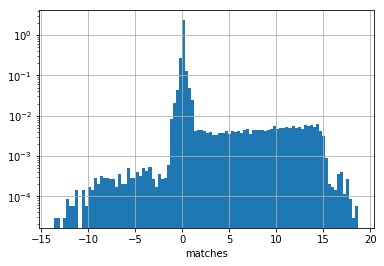

In [6]:
threshold = 0
f1 = m62[m62 > threshold]
f2 = m62[m62 <= -threshold]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('matches')

plt.show()

In [2]:
act = tmpl.format('relevant_activations')
with open(act, 'rb') as f:
    act = pickle.load(f)

In [3]:
markup = tmpl.format('relevant_markup')
with open(markup, 'rb') as f:
    markup = pickle.load(f)

In [4]:
act62 = act[:, 62]

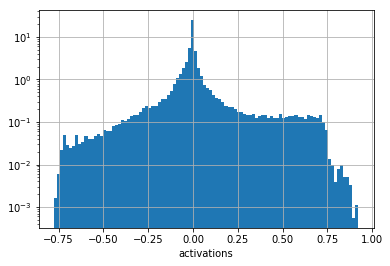

In [8]:

plt.hist(act62, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('activations')

plt.show()

In [5]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(m62, 0.001, None, 'blue')
plt.yscale('log')
plt.xlabel('matches')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/matches.png',
    dpi=900
)
plt.show()

NameError: name 'm62' is not defined

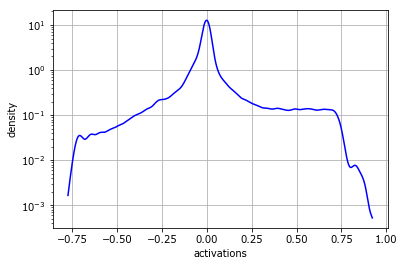

In [19]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(act62, 0.0001, None, 'blue')
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/activations.png',
    dpi=900
)
plt.show()

In [7]:
from helmo.util.plot.plot_helpers import density_plot

selected_indices = np.array(np.array(markup) + 1, dtype=bool)

In [8]:
nns_act62 = act62[selected_indices]

In [9]:
import numpy as np

print(nns_act62.shape)
print(nns_act62[:100])
min_ = np.min(act62)
max_ = np.max(act62)

(7996,)
[ 0.03987525  0.24359564  0.13936374  0.01275242  0.33905667  0.23092057
  0.49802893  0.7179312   0.6440741   0.72047305  0.68238884  0.27751622
  0.7226443   0.66829014  0.6769268   0.35996893  0.62734854  0.4216515
  0.53920376 -0.07121509  0.5742651   0.7341397   0.23616292  0.7350702
  0.13083465  0.35654765  0.5455406   0.41869763  0.5783358   0.61539644
  0.6135536   0.62634987  0.23542795  0.21027555  0.6333601   0.036227
  0.43719196  0.35494202  0.13239472  0.6450477   0.7428283   0.7066073
  0.6975089   0.28573078  0.42003262  0.20334533  0.45254168  0.40931424
  0.15804431  0.5475083   0.12762508  0.30116114  0.46461856  0.6587762
  0.34424582  0.47947675  0.7382973   0.43743163  0.48655224  0.3983338
  0.6633929   0.5986025   0.6500519   0.72113675  0.61620504  0.70613456
  0.02858962  0.5844811   0.5168905   0.2948563   0.41682157  0.40695137
  0.5016543   0.3709565   0.7006538   0.62645507 -0.00999689  0.631873
  0.37047824  0.10538723 -0.12101641  0.3286183   0.

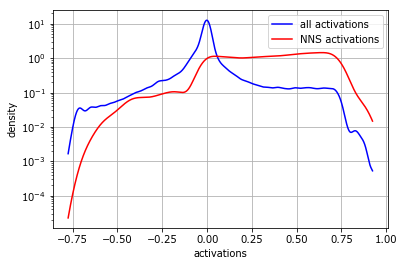

In [13]:
import os

import matplotlib.pyplot as plt

density_plot(act62, 0.0001, 'all activations', 'blue')
density_plot(nns_act62, 0.0001, 'NNS activations', 'red', [min_, max_])
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.legend(loc='best')
plt.savefig(
    os.path.join(prefix, 'plots/activations_and_nns_activations.png'),
    dpi=900
)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


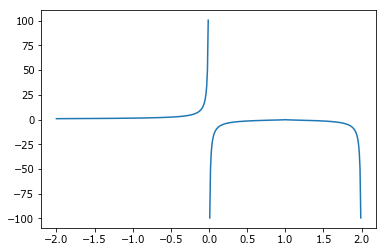

In [15]:
x = [0.01*i for i in range(-200, 200)]
y = [1 / np.log(abs(xx-1.)) for xx in x]

plt.plot(x, y)
plt.show()

In [171]:
! export PYTHONPATH="~/h-elmo:~/learning-to-learn"

In [173]:
! echo $PYTHONPATH

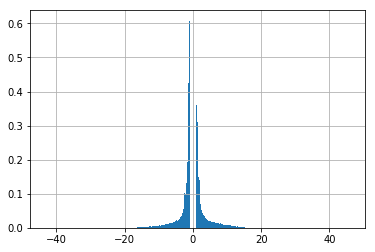

In [25]:
f1 = m[m > 1.]
f2 = m[m < -1.]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=1000, density=True)
plt.grid()
plt.show()

In [ ]:
tmpl = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level0_0/NNS/{}.pickle'
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

In [ ]:
act = tmpl.format('activations')
with open(act, 'rb') as f:
    a = pickle.load(f)
    


In [ ]:
stddevs = tmpl.format('match_stddevs')
with open(stddevs, 'rb') as f:
    std = pickle.load(f)

print(std)
print(max(std))
print(np.argmax(std))

In [1]:
import tensorflow as tf


def get_all_values_except_specified(tensor, excluded):
    with tf.name_scope('get_all_values_except_specified'):
        tensor = tf.reshape(tensor, [-1])
        excluded = tf.reshape(excluded, [-1])
        excluded_shape = tf.shape(excluded)
        tensor_expanded = tf.reshape(tensor, [-1, 1])
        multiples = tf.concat([[1], excluded_shape], 0)
        tensor_expanded = tf.tile(tensor_expanded, multiples)
        masks = tf.cast(tf.equal(tf.cast(tensor_expanded, tf.int32), tf.cast(excluded, tf.int32)), tf.int32)
        mask = tf.reduce_sum(masks, [1])
        mask = tf.cast(tf.cast(mask, dtype=tf.bool), dtype=tf.int32) - 1
        return tf.boolean_mask(tensor, mask)
    

tensor, num_dims, axes, output = (
                    [[[1, 2], [3, 4]], [[5, 6], [7, 8]]],

                    5,

                    [0, 2, 4],

                    [[[[[1, 2]], [[3, 4]]], [[[5, 6]], [[7, 8]]]]],
                )

if not tf.contrib.framework.is_tensor(tensor):
    tensor = tf.constant(tensor)
if not tf.contrib.framework.is_tensor(axes):
    axes = tf.constant(axes, dtype=tf.int32)
sh = tf.shape(tensor, out_type=tf.int32)
nd = tf.shape(sh, out_type=tf.int32)[0]
assert_axes_smaller_than_num_dims = tf.assert_less(
    axes, num_dims, message='`axes` has to be less than `num_dims`')
check_num_dims = tf.assert_greater_equal(
    num_dims, nd,
    message='`num_dims` has to be greater or equal to number of dimensions in `tensor`'
)
ass_axes_bigger_or_equal_than_num_dims = tf.assert_greater_equal(axes, -num_dims)

negative_axes_mask = tf.cast(axes < 0, tf.int32)
axes += negative_axes_mask * num_dims

ones_for_expansion = tf.ones(tf.reshape(num_dims - nd, [1]), dtype=tf.int32)
shape_for_expansion = tf.concat([sh, ones_for_expansion], 0)

tensor = tf.reshape(tensor, shape_for_expansion)

# remained_axes = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
# perm = tf.concat([axes, remained_axes], 0)
updates = tf.range(0, num_dims, 1, dtype=tf.int32)
remained_positions = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
indices = tf.concat([axes, remained_positions], 0)
indices = tf.reshape(indices, [-1, 1])
perm_shape = tf.reshape(num_dims, [1])
perm = tf.scatter_nd(indices, updates, perm_shape)

with tf.control_dependencies([check_num_dims, assert_axes_smaller_than_num_dims, ass_axes_bigger_or_equal_than_num_dims]):
    tensor = tf.transpose(tensor, perm=perm)
    

with tf.Session() as sess:
    print(sess.run(tensor))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[[[[1 2]]

   [[3 4]]]]



 [[[[5 6]]

   [[7 8]]]]]


In [1]:
import numpy as np

from helmo.util.scripts.text_neuron_correlation import compute_stats

num_unrollings = 20
num_units = 4

# a = np.random.rand(num_units, num_unrollings)

m = np.random.choice([-1, 1, 0], num_unrollings)
a = np.stack([m]*num_units, 1)
print(a)

stats = compute_stats(a, m)
print(stats)

[[-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]]
{'markup': array([-1,  1,  0, -1,  1, -1,  1, -1,  0,  0, -1, -1, -1, -1,  0,  1,  0,
        1,  0,  1]), 'relevant_markup': [-1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1], 'relevant_activations': array([[-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1]]), 'matches': array([[0.75      , 0.75      , 0.75      , 0.75      ],
       [1.33333333, 1.33333333, 1.33333333, 1.33333333],
       [0.75      , 

In [161]:
import numpy as np


def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part


def get_kth_digit(number, k, default='0'):
    """Returns k-th digit. For example, in number 123.45 1 
    is 2nd digit, 3 is zeroth and 5 is -2nd. 
    If the number does not have such a digit default is returned.
    Args:
        number: float or str convertable to float
        k: integer
    Returns:
        str"""
    if isinstance(number, str):
        number = float(number)
    int_part = get_int_part(number)
    frac_part = get_frac_part(number)
    number = int_part + frac_part
    k = len(int_part) - k - 1
    if 0 <= k < len(number):
        return number[k]
    else:
        return default
    
    
def get_first_nonzero_digit_pos(n):
    if n == 0:
        return None
    int_part = get_int_part(n)
    frac_part = get_frac_part(n)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


def get_acc_num_digits(std, acc):
    if std == 0:
        return None
    
    std_err = std * acc
    
    nz_err = get_first_nonzero_digit_pos(std_err)
    
    digit_1_pos_higher = get_kth_digit(std, nz_err+1)
    
    higher_digit_change = get_kth_digit(std + std_err, nz_err+1) != digit_1_pos_higher or \
        get_kth_digit(std - std_err, nz_err+1) != digit_1_pos_higher

    if higher_digit_change:
        nz_err += 1
    return nz_err

for std in np.linspace(0, 1, 101):
    last_digit = get_acc_num_digits(std, 0.2)
    print(std, last_digit)

0.0 None
0.01 -2
0.02 -2
0.03 -2
0.04 -2
0.05 -2
0.06 -2
0.07 -2
0.08 -2
0.09 -1
0.1 -1
0.11 -1
0.12 -1
0.13 -2
0.14 -2
0.15 -2
0.16 -2
0.17 -1
0.18 -1
0.19 -1
0.2 -1
0.21 -1
0.22 -1
0.23 -1
0.24 -1
0.25 -1
0.26 -1
0.27 -1
0.28 -1
0.29 -1
0.3 -1
0.31 -1
0.32 -1
0.33 -1
0.34 -1
0.35000000000000003 -1
0.36 -1
0.37 -1
0.38 -1
0.39 -1
0.4 -1
0.41000000000000003 -1
0.42 -1
0.43 -1
0.44 -1
0.45 -1
0.46 -1
0.47000000000000003 -1
0.48 -1
0.49 -1
0.5 -1
0.51 -1
0.52 -1
0.53 -1
0.54 -1
0.55 -1
0.56 -1
0.5700000000000001 -1
0.58 -1
0.59 -1
0.6 -1
0.61 -1
0.62 -1
0.63 -1
0.64 -1
0.65 -1
0.66 -1
0.67 -1
0.68 -1
0.6900000000000001 -1
0.7000000000000001 -1
0.71 -1
0.72 -1
0.73 -1
0.74 -1
0.75 -1
0.76 -1
0.77 -1
0.78 -1
0.79 -1
0.8 -1
0.81 -1
0.8200000000000001 -1
0.8300000000000001 -1
0.84 0
0.85 0
0.86 0
0.87 0
0.88 0
0.89 0
0.9 0
0.91 0
0.92 0
0.93 0
0.9400000000000001 0
0.9500000000000001 0
0.96 0
0.97 0
0.98 0
0.99 0
1.0 0


In [138]:
get_kth_digit(123.45678, -4)

'7'

In [132]:
def get_first_nonzero_digit_pos_for_std(std, acc):
    if std == 0:
        return None
    std_fraction = std * acc
    int_part = get_int_part(std_fraction)
    frac_part = get_frac_part(std_fraction)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


get_first_nonzero_digit_pos_for_std(0.0123456, 1000)

1

In [116]:
def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part

len(get_frac_part(2.2250738585072014e-308))

324

In [22]:
import numpy as np

bins = np.histogram_bin_edges([1], 8, [1., 9.])
a = np.array([-1., 0., 1., 1.5, 2.5, 10.4])
d = np.digitize(a, bins)
print(d)

[0 0 1 1 2 9]


In [3]:
import timeit

import numpy as np


a = np.zeros([10**4, 10**4])
b = np.zeros([10**4, 10**4])

N = 100

t = timeit.timeit(
    stmt="c = a + b",
    globals=dict(a=a, b=b),
    number=N
)

print(t / N)

0.2169441995676607


In [2]:
import tensorflow as tf

a = tf.Variable(0, trainable=False)

op = tf.assign_add(a, 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([op, op])
    print(a.eval(sess))

1


In [2]:
h = net.get_default_hooks()

In [3]:
print(h)

{'inputs': <tf.Tensor 'inps_and_lbls/inps:0' shape=(?, ?) dtype=int32>, 'labels': <tf.Tensor 'inps_and_lbls/lbls:0' shape=(?, ?) dtype=int32>, 'train_op': <tf.Operation 'gpu0_gradients/Adam' type=NoOp>, 'learning_rate': <tf.Tensor 'learning_rate:0' shape=<unknown> dtype=float32>, 'loss': <tf.Tensor 'loss_and_metrics/averaging_metrics/add:0' shape=() dtype=float32>, 'predictions': <tf.Tensor 'concat:0' shape=(?, ?, 100) dtype=float32>, 'validation_inputs': <tf.Tensor 'inps_and_lbls/inps:0' shape=(?, ?) dtype=int32>, 'validation_labels': <tf.Tensor 'inps_and_lbls/lbls:0' shape=(?, ?) dtype=int32>, 'validation_predictions': <tf.Tensor 'concat_1:0' shape=(?, ?, 100) dtype=float32>, 'reset_validation_state': <tf.Operation 'inference/group_deps' type=NoOp>, 'randomize_sample_state': <tf.Operation 'inference/group_deps_1' type=NoOp>, 'reset_train_state': <tf.Operation 'train/group_deps' type=NoOp>, 'randomize_train_state': <tf.Operation 'train/group_deps_1' type=NoOp>, 'dropout': <tf.Tensor '

In [4]:
print(list(net._hooks.keys()))

['inputs', 'labels', 'train_op', 'learning_rate', 'momentum', 'loss', 'predictions', 'validation_inputs', 'validation_labels', 'validation_predictions', 'reset_validation_state', 'randomize_sample_state', 'reset_train_state', 'randomize_train_state', 'dropout', 'saver', 'correlation', 'correlation_values', 'correlation2', 'correlation12', 'correlation_values_1-2', 'update_level0_0_hidden_state_hist', 'entropy_level0_0_hidden_state', 'level0_0_hidden_state', 'level0_1_hidden_state', 'level0_0_axis_quarters', 'level0_1_axis_quarters', 'validation_loss', 'subgraph_savers']


In [3]:
print(h['update_level0_0_hidden_state_hist'])

Tensor("inference/gpu0/rnns/level0/_add_hidden_state_accumulation_ops/AssignAdd:0", shape=(100, 100), dtype=int32_ref)


In [1]:
import tensorflow as tf

g = tf.group()

with tf.Session() as sess:
    print(sess.run(g))

None


In [3]:
from sympy import *

k, n, p = symbols('k n p')

p = Product(k**(k * binomial(n, k) * p**k * (1-p)**(n-k)), (k, 0, n))

In [4]:
r = p.doit()

In [5]:
print(r)

Product(k**(k*p**k*(-p + 1)**(-k + n)*binomial(n, k)), (k, 0, n))


In [47]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
import numpy as np


def load_line(file_name):
    x = []
    y = []
    with open(file_name) as f:
        for line in f.readlines():
            xx, yy = line.split()
            x.append(float(xx))
            y.append(float(yy))
    return [x, y]


def load_lines(file_names):
    lines = []
    for fn in file_names:
        lines.append(load_line(fn))
    return lines


def load_groups_of_lines(groups):
    lines = {}
    for label, file_names in groups.items():
        lines[label] = load_lines(file_names)
    return lines


def plot_similar_lines(lines, color, lw):
    for line in lines:
        plt.plot(line[0], line[1], lw=lw, color=color)
        
        
def add_legend(artists, labels, position):
    if position == 'outside':
        pos_dict = dict(
            bbox_to_anchor=(1.05, 1),
            loc=2,
        )
    elif position == 'upper_right':
        pos_dict = dict(
            bbox_to_anchor=(.95, .95),
            loc=1,
        )
    elif position == 'upper_left':
        pos_dict = dict(
            bbox_to_anchor=(.05, .95),
            loc=2,
        )
    elif position == 'best':
        pos_dict = {'loc': 'best'}
    ax = plt.gca()
    lgd = ax.legend(
        artists,
        labels,
        **pos_dict,
    )
    return lgd


def form_symlog_kwargs(groups):
    x_nonzero_values = []
    y_nonzero_values = []
    for group_of_lines in groups.values():
        for line in group_of_lines:
            x_nonzero_values += [x for x in line[0] if x != 0]
            y_nonzero_values += [y for y in line[1] if y != 0]
    xkwargs = dict(
        linthreshx=np.min(np.abs(x_nonzero_values))
    )
    ykwargs = dict(
        linthreshy=np.min(np.abs(y_nonzero_values))
    )
    return xkwargs, ykwargs


def plot_groups_of_lines(
        groups,
        single_lines,
        group_colors,
        single_colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        xaxis_format,
        start_idx,
        legend_position,
        dpi,
        save_path,
        show,
):
    custom_lines = []
    labels = []
    for (label, group_of_lines), color in zip(groups.items(), group_colors):
        labels.append(label)
        custom_lines.append(Line2D([0], [0], color=color, lw=4))
        plot_similar_lines(group_of_lines, color, lw)
    for (label, line), color in zip(single_lines.items(), single_colors):
        labels.append(label)
        custom_lines.append(Line2D([0], [0], color=color, lw=4))
        plt.plot(line[0][start_idx:], line[1][start_idx:], color=color, lw=lw)
    plt.grid(which='both')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    xkwargs, ykwargs = form_symlog_kwargs(groups)
    if xscale != 'symlog':
        xkwargs = {}    
    if yscale != 'symlog':
        ykwargs = {}
    plt.xscale(xscale, **xkwargs)
    plt.yscale(yscale, **ykwargs)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(xaxis_format)
    bbox_extra_artists = [add_legend(custom_lines, labels, legend_position)]
    if save_path is not None:
        os.makedirs(os.path.split(save_path)[0], exist_ok=True)
        plt.savefig(
            save_path,
            bbox_extra_artists=bbox_extra_artists,
            bbox_inches='tight',
            dpi=dpi,
        )
    if show:
        plt.show()
        
        
def load_single_lines(file_names):
    lines = {}
    for label, fn in file_names.items():
        lines[label] = load_line(fn)
    return lines
        
        
def main(
        groups_of_file_names,
        file_names,
        group_colors,
        single_colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        xaxis_format,
        start_idx,
        legend_position,
        dpi,
        save_path,
        show,
):
    groups = load_groups_of_lines(groups_of_file_names)
    single_lines = load_single_lines(file_names)
    plot_groups_of_lines(
        groups,
        single_lines,
        group_colors,
        single_colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        xaxis_format,
        start_idx,
        legend_position,
        dpi,
        save_path,
        show,
    )

In [54]:
from collections import OrderedDict

prefix = 'expres/resrnn/word/restore_tt'
postfix = 'results_shifted/loss_valid.txt'

nets = ['ch100_w200', 'ch100_w100', 'ch100_w50']
numbers = list(range(10))

groups_of_file_names = OrderedDict()
for net in nets:
    groups_of_file_names[net.replace('_', ' + ')] = []
    for i in numbers:
        file_name = os.path.join(prefix, net, str(i), postfix)
        groups_of_file_names[net.replace('_', ' + ')].append(file_name)
        
print(list(groups_of_file_names.keys()))

pre_x, pre_y = load_line(os.path.join(prefix, 'loss_pretrain.txt'))

['ch100 + w200', 'ch100 + w100', 'ch100 + w50']


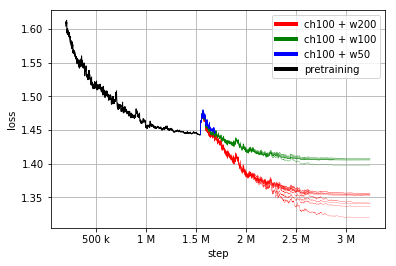

In [55]:
plt.plot(pre_x[200:], pre_y[200:], color='black', lw=1)
main(
    groups_of_file_names,
    {'pretraining': os.path.join(prefix, 'loss_pretrain.txt')},
    ['red', 'green', 'blue'],
    ['black'],
    0.2,
    'step',
    'loss',
    'linear',
    'linear',
    mpl.ticker.EngFormatter(),
    200,
    'best',
    900,
    os.path.join(prefix, 'plots/pre_and_post_training.png'),
    True
)